# Figure 10, 11, and 12: IWV & LWP distribution cloudy and clear

*Figure 10 caption:*  
Histogram of percentage with overlaid smoothed distribution of IWV for a)
all columns, b) cloudy columns and c) clear columns for ICON-LEM (red) and HATPRO
(turquoise). Histogram bin width 1.2 kg m−2

*Figure 11 caption:*  
a) Histogram of percentage with overlaid smoothed distribution of LWP for a)
ICON-LEM and b) HATPRO. Histogram bin width 50 g m−2. Only cases with LWP ≥ 10 g m−2
are included in the comparison. The grey shaded area marks the values with increased uncertainties.
b) Zoom in of a) for LWP
values up to 500 g m−2 and linear y-axis. Histogram bin width is 25 g m−2.

seaborn version > 0.11.1

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#%matplotlib notebook
#%matplotlib inline
sns.__version__


'0.12.2'

## Differentiate between cloudy and clear sky using Cloudnet

For ICON I use a precipitation flag. If the threshold is set to lower than 0.01 kg/m^2 then a unrealistically high number of cases is excluded. Therefore, I set the limit to 0.1 kg/m^2

### 1. Data


In [2]:
# Observation cloudnet
cloudnet_file = "data/nyalesund_obs_cn_classification_202008-12_nospinup.nc"
cn_obs_ds = xr.open_dataset(cloudnet_file) # 30 second steps, 0 = clear, 1-7 = cloudy, >7 no clouds but other stuff

# Model cloudnet
cloudnet_file = "data/model/nyalesund_model_cn_classification_202008-12_nospinup.nc"
cn_model_ds = xr.open_dataset(cloudnet_file) # 2: clear, 3-7 cloudy

In [3]:
# Integrated values:
# All IWV and LWP in 1 minute steps without spinup period.
intvals_file="data/cut_spinup/nyalesund_icon_hatpro_precip_intvals_202008-12.nc"
intvals_ds = xr.open_dataset(intvals_file) # 1 minute steps

# One set for hatpro
intvals_hatpro = intvals_ds[["prw", "clwvi"]].where(np.isnan(intvals_ds.flag) & np.isnan(intvals_ds.flag_tbx),
                                                    drop = True)
# Add variable for clouds/clear:
intvals_hatpro["clouds"] = (("time"), np.zeros(len(intvals_hatpro.time)))

# One set for ICON with precipitation flags and Hatpro flags
#intvals_icon = intvals_ds.where(np.isnan(intvals_ds.flag) & np.isnan(intvals_ds.flag_tbx) &
 #                             ((intvals_ds.RAIN_GSP_lem < 1e-2) & (intvals_ds.RAIN_CON_lem < 1e-2)), drop = True)

In [4]:
# One set for ICON with precipitation flags 
intvals_icon = intvals_ds[["IWV_lem", "LWP_lem"]].where((intvals_ds.RAIN_GSP_lem < 5e-2) &
                                                        (intvals_ds.RAIN_CON_lem < 5e-2) &
                                                        np.isnan(intvals_ds.flag) &
                                                        np.isnan(intvals_ds.flag_tbx), drop = True)
# Add variable for clouds/clear:
intvals_icon["clouds"] = (("time"), np.zeros(len(intvals_icon.time)))

In [5]:
plt.figure()
plt.plot(intvals_icon.LWP_lem[intvals_icon.LWP_lem>1].time, intvals_icon.LWP_lem[intvals_icon.LWP_lem>1])


<IPython.core.display.Javascript object>

Change the timestep in the cloudnet files because the intvals are given for every minute.

In [5]:
# Only take every second value from cloudnet observations because the data is for every 30s.
#obs_mask = np.linspace(0,len(cn_obs_ds.time[1:]),int(len(cn_obs_ds.time[1:])/2), dtype=int, endpoint=False)
#np.all(obs_mask%2 == 0) all true

cn_obs_sub = cn_obs_ds.where(cn_obs_ds.time.dt.second>40, drop=True)

cn_model_sub = cn_model_ds.where((cn_model_ds.time.dt.second >= 50) &
                                 (cn_model_ds.time.dt.second < 59), drop= True)


Now check if a certain timestep had clouds or was clear. 
Model levels from 24 on so that they are below 11900 m because the observations end at 12km.

In [6]:
# Exclude cases where the instrument is rotating
intvals_hatpro = intvals_hatpro.where((~np.isnan(intvals_hatpro.clwvi) ) & (~np.isnan(intvals_hatpro.prw) ), drop = True) 


In [7]:
# select times where model cloudnet has clouds
for i in range(len(intvals_icon.time)):
    intvals_icon.clouds.values[i] = np.any(cn_model_sub.nclass.values[(intvals_icon.time.values[i] >= cn_model_sub.time.values) 
                                                       & (intvals_icon.time.values[i-1] < cn_model_sub.time.values),24:] > 2)

In [8]:
#Select times where cloudnet shows clouds
for i in range(len(intvals_hatpro.time)):
    intvals_hatpro.clouds.values[i] = np.any((cn_obs_sub.target_classification.values[(intvals_hatpro.time.values[i] >= cn_obs_sub.time.values) 
                                                       & (intvals_hatpro.time.values[i-1] < cn_obs_sub.time.values),:] > 1 ) & 
                                             (cn_obs_sub.target_classification.values[(intvals_hatpro.time.values[i] >= cn_obs_sub.time.values) 
                                                       & (intvals_hatpro.time.values[i-1] < cn_obs_sub.time.values),:] < 8 ))

## 2. Plots

<IPython.core.display.Javascript object>


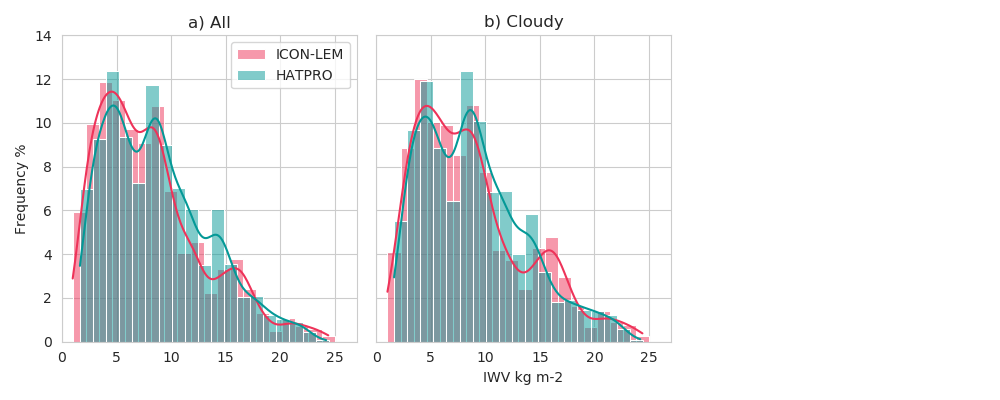

8.108411583803699 8.722556 0.9459259994444231 0.6984439492225647


In [48]:
sns.set_style("whitegrid")

stat_type = "percent"
fig = plt.figure(figsize=(10,4))

#ax = plt.gca()

ax1 = fig.add_subplot(131)
plt.title("a) All")
sns.histplot(intvals_icon.IWV_lem, binwidth= 1.2, stat=stat_type,
             kde=True, kde_kws={"bw_adjust":2}, color="#EE3359", label="ICON-LEM")
sns.histplot(intvals_hatpro.prw, binwidth= 1.2, stat=stat_type, 
             kde=True, kde_kws={"bw_adjust":2}, color="#049997", label="HATPRO")
plt.xlabel("")
plt.xlim(0,27)
plt.ylim(0, 14)
plt.legend()
plt.ylabel("Frequency %")

ax2 = fig.add_subplot(132)
plt.title("b) Cloudy")
sns.histplot(intvals_icon.IWV_lem.where(intvals_icon.clouds == True, drop = True), binwidth= 1.2, stat=stat_type,
             kde=True, kde_kws={"bw_adjust":2}, color="#EE3359")
sns.histplot(intvals_hatpro.prw.where(intvals_hatpro.clouds == True, drop = True), binwidth= 1.2, stat=stat_type, 
             kde=True, kde_kws={"bw_adjust":2}, color="#049997")
plt.xlabel("IWV kg m-2")
plt.ylabel("")
plt.xlim(0,27)
plt.ylim(0, 14)
ax2.yaxis.set_ticklabels([])

ax3 = fig.add_subplot(133, sharey=ax2)
plt.title("c) Clear")
sns.histplot(intvals_icon.IWV_lem.where(intvals_icon.clouds == False, drop = True), binwidth= 1.2, stat=stat_type,
             kde=True, kde_kws={"bw_adjust":2}, color="#EE3359")
sns.histplot(intvals_hatpro.prw.where(intvals_hatpro.clouds == False, drop = True), binwidth= 1.2, stat=stat_type, 
             kde=True, kde_kws={"bw_adjust":2}, color="#049997")
plt.xlabel("")
plt.ylabel("")
plt.xlim(0,27)
plt.ylim(0,14)

plt.tight_layout()

plt.savefig("fig_10_IWV_distrib_cloudy_clear_revised.png",
           format='png', dpi=300)

print(np.nanmean(intvals_icon.IWV_lem), np.nanmean(intvals_hatpro.prw),
      stats.skew(intvals_icon.IWV_lem), stats.skew(intvals_hatpro.prw))

## Liquid water path

Text(0, 0.5, '')

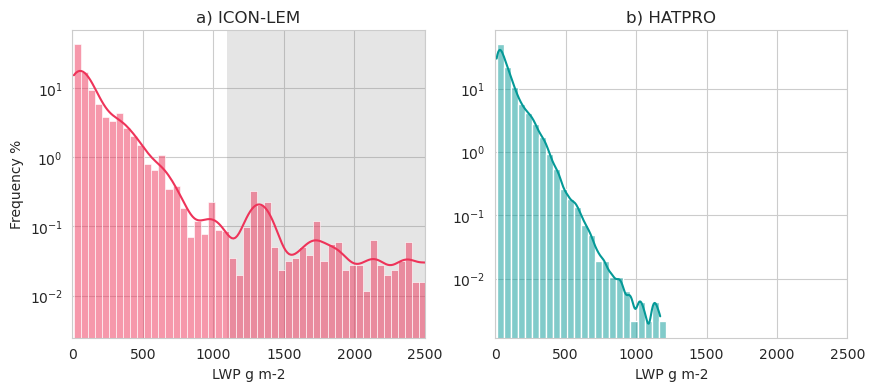

In [9]:
sns.set_style("whitegrid")

# Threshold below which data will not be included.
lwplim = 0.01
fig = plt.figure(figsize=(10,4))

stat_type="percent"

ax1 = fig.add_subplot(121)
plt.axvspan(1100, 2500, color='grey', alpha=0.2, lw=0)
sns.histplot(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim),drop = True)*1000,
             binwidth= 50, stat=stat_type, kde=True, kde_kws={"bw_adjust":2}, color="#EE3359")
plt.xlim(0,2500)
plt.title("a) ICON-LEM")
plt.xlabel("LWP g m-2")
ax1.set_yscale('log')
plt.ylabel("Frequency %")

ax2 = fig.add_subplot(122) #, sharey=ax1)
sns.histplot(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True)*1000,
             binwidth= 50, stat=stat_type, kde=True, kde_kws={"bw_adjust":2}, color="#049997")
plt.xlim(0,2500)
plt.title("b) HATPRO")
plt.xlabel("LWP g m-2")
ax2.set_yscale('log')
plt.ylabel("")

#plt.savefig("fig_11_LWP_distribution_logscale_revised.png", bbox_layout="tight", format='png', dpi=300)

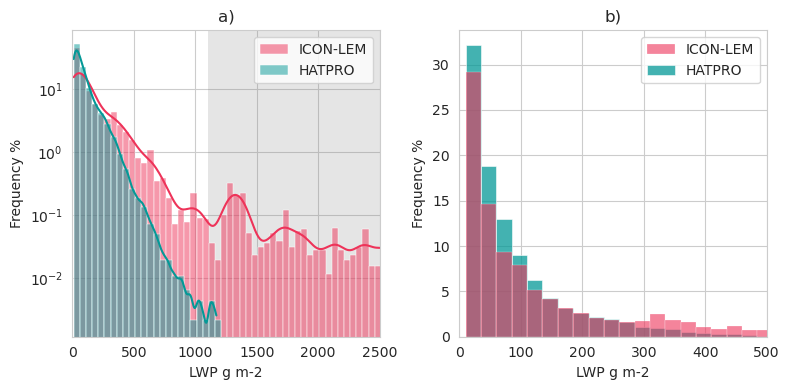

In [26]:
sns.set_style("whitegrid")

# Threshold below which data will not be included.
lwplim = 0.01
fig = plt.figure(figsize=(8,4))

stat_type="percent"

ax1 = fig.add_subplot(121)
plt.axvspan(1100, 2500, color='grey', alpha=0.2, lw=0)
sns.histplot(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim),drop = True)*1000,
             binwidth= 50, stat=stat_type, kde=True, kde_kws={"bw_adjust":2}, color="#EE3359", label="ICON-LEM")
sns.histplot(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True)*1000,
             binwidth= 50, stat=stat_type, kde=True, kde_kws={"bw_adjust":2}, color="#049997", label="HATPRO")
plt.xlim(0,2500)
plt.xlim(0,2500)
plt.title("a)")
plt.xlabel("LWP g m-2")
ax1.set_yscale('log')
plt.ylabel("Frequency %")
plt.legend()

ax2 = fig.add_subplot(122)
sns.histplot(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim),
                                         drop = True)*1000, binwidth=25, kde=False,
                                         stat=stat_type, color="#049997", label="HATPRO")
sns.histplot(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim),drop = True)*1000,
             binwidth= 25, stat=stat_type, kde=False, kde_kws={"bw_adjust":2}, color="#EE3359", alpha=0.6, label="ICON-LEM")
plt.xlim(0,500)
plt.xlabel("LWP g m-2")
plt.title("b)")
plt.ylabel("Frequency %")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in [1,0]], [labels[idx] for idx in [1,0]])

plt.tight_layout()
plt.savefig("fig_11_LWP_distribution_revised2.pdf", format='pdf', dpi=300, bbox_inches="tight")

In [37]:
print("ICON-LEM:", np.nanmean(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim), drop = True)*1000), 
      stats.skew(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim), drop = True)*1000),
      np.nanmedian(intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & (intvals_icon.LWP_lem > lwplim), drop = True)*1000),
      "HATPRO:", np.nanmean(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True)*1000),
      stats.skew(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True)*1000),
     np.nanmedian(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True)*1000))


max(intvals_hatpro.clwvi.where((intvals_hatpro.clouds == True) & (intvals_hatpro.clwvi > lwplim), drop = True).values)*1000

ICON-LEM: 168.15580014730548 4.286309485661175 75.82465838968723 HATPRO: 91.34834 2.36838436126709 58.274635


1171.0174083709717

## 4. Numbers

Getting cloudy vs. clear from the cloudnet comparisons. For Hatpro the times which have nan because of the scanning pattern are not included. 

 **Remaining in model**
 
 |      | clear   | cloudy | total
 |-------|---------|---------|-------
 | number | 24774 | 83398 | --
 | percent | 22.9 | 77.1  | 100
 
  **Remaining in HATPRO selection**
 
 |      | clear   | cloudy | total
 |-------|---------|---------|-------
 | number | 27891 (before 29816) | 73563 | 101454
 | percent | 27.5 | 72.5| 100
 
 Getting cloudy cases with LWP above 10g m-2 detected/simulated
 
 model: 
 

In [41]:
ncloudy_icon = sum((intvals_icon.clouds.values == True))
nclear_icon = sum((intvals_icon.clouds.values == False))

ntot_icon = (nclear_icon + ncloudy_icon)

pcloudy_icon = ncloudy_icon/ntot_icon*100
pclear_icon = nclear_icon/ntot_icon*100

print("ICON-LEM #:", ncloudy_icon, nclear_icon)
print("ICON %:", pcloudy_icon, pclear_icon)

ICON-LEM #: 83398 24774
ICON %: 77.0975853270717 22.902414672928302


In [43]:
ncloudy_hatpro = sum((intvals_hatpro.clouds.values == True))
nclear_hatpro = sum((intvals_hatpro.clouds.values == False))

ntot_hatpro = (nclear_hatpro + ncloudy_hatpro)

pcloudy_hatpro = ncloudy_hatpro/ntot_hatpro*100
pclear_hatpro = nclear_hatpro/ntot_hatpro*100

print("Hatpro #:", ncloudy_hatpro, nclear_hatpro)
print("Hatpro %:", pcloudy_hatpro, pclear_hatpro)

Hatpro #: 73563 27891
Hatpro %: 72.50872316517831 27.491276834821694


### 4.2 Liquid and Mixed-phase vs Ice

Distinguish columns by those where there are clouds and then an LWP above 10 g m-2. I could also add other categories.

**HATPRO:** 

|           | ncloudy | lwp>5 | lwp > 10 | lwp > 20 |
|-----------|---------|--------|---------|----------|
|number     | 73563   | 51424  | 46529   | 39293    | (before  71638 | 50243 | 45508 | 38498 )
|percentage | 100     |   70   |   63    |    53    | (before  100   |70.13 | 63.52 | 53.74 |)

**ICON-LEM:**

|           | ncloudy | lwp>0 | lwp>5 | lwp>10 | lwp > 20 |
|-----------|---------|-------|-------|--------|----------|
|number     | 95735   | 33522 | 28090 |  25457 | 21764 | (before: 40793 | 33929 | 30855  | 26461 )
|percentage | 100     | 40    |    34 |    31  |  26   | (before: 42.61 35.44 | 32.23  | 27.64 )

Even if the limit is set to LWP > 0 in ICON the percentage of columns that contain liquid water from the total number of columns with clouds lies by 40%

In [47]:
ncloudy_hatpro
ncloudy_icon

nlwp_10_hatpro = intvals_hatpro.clwvi.where((intvals_hatpro.clouds.values == True) & 
                           (intvals_hatpro.clwvi> 0.01), drop=True ).time.size
nlwp_05_hatpro = intvals_hatpro.clwvi.where((intvals_hatpro.clouds.values == True) & 
                           (intvals_hatpro.clwvi> 0.005), drop=True ).time.size
nlwp_20_hatpro = intvals_hatpro.clwvi.where((intvals_hatpro.clouds.values == True) & 
                           (intvals_hatpro.clwvi> 0.02), drop=True ).time.size

nlwp_00_icon = intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & 
                                           (intvals_icon.LWP_lem>0.00), drop=True).time.size
nlwp_10_icon = intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & 
                                           (intvals_icon.LWP_lem>0.01), drop=True).time.size
nlwp_05_icon = intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & 
                                           (intvals_icon.LWP_lem>0.005), drop=True).time.size
nlwp_20_icon = intvals_icon.LWP_lem.where((intvals_icon.clouds == True) & 
                                           (intvals_icon.LWP_lem>0.02 ), drop=True).time.size
# Get percentage
plwp_10_hatpro = nlwp_10_hatpro/ncloudy_hatpro * 100
plwp_05_hatpro = nlwp_05_hatpro/ncloudy_hatpro * 100
plwp_20_hatpro = nlwp_20_hatpro/ncloudy_hatpro * 100

plwp_00_icon = nlwp_00_icon/ncloudy_icon * 100
plwp_10_icon = nlwp_10_icon/ncloudy_icon * 100
plwp_05_icon = nlwp_05_icon/ncloudy_icon * 100
plwp_20_icon = nlwp_20_icon/ncloudy_icon * 100

print(ncloudy_hatpro, ncloudy_icon)
print("hatpro #: " , nlwp_05_hatpro, nlwp_10_hatpro, nlwp_20_hatpro)
print("hatpro %: ", plwp_05_hatpro, plwp_10_hatpro, plwp_20_hatpro)
print("icon #: " , nlwp_00_icon, nlwp_05_icon, nlwp_10_icon, nlwp_20_icon)
print("icon %: ", plwp_00_icon, plwp_05_icon, plwp_10_icon, plwp_20_icon)

73563 83398
hatpro #:  51424 46529 39293
hatpro %:  69.90470752960047 63.250547150061855 53.41408044805133
icon #:  33522 28090 25457 21764
icon %:  40.19520851818989 33.681862874409454 30.52471282284947 26.096549077915537
